# **Title Name :  인공호흡기 압력예측**

<p style="font-weight:bolder; font-size : 21px">
    Step : [COPY] RNN-LSTM Simple Modeling Add Fetures[step:4]
<p>
<p style="font-weight:bolder; font-size : 21px">
   RegDate : 2023.11.14
<p>

------------------------------------------------------------

## 1. 설정
------------------------------------------------------------

In [ ]:
!pip install -qqq transformers

In [ ]:
#==================================================
# 모듈 불러오기
#==================================================

# 시스템
import os
import sys
import random
from time import time

# 데이터분석 4종세트
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 피쳐엔지니어링
from scipy.fft import fft, fftfreq
from scipy.signal import blackman
from scipy.signal import hilbert, chirp



# 파이토치
from torch import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torchvision
from torchvision import transforms
# from torchinfo import summary    # require : pip install -qqq torchinfo

# 트랜스포머
from transformers import get_linear_schedule_with_warmup

# 사이킷런
import sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# 유틸기능
import gc
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


# 그래프 테마
sns.set_theme(style='whitegrid')
plt.style.use(['dark_background'])


In [ ]:
#==================================================
# 시드설정
#==================================================
# 시드설정
SEED = 2023
def seed_everything(SEED):
    random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# deterministic 설정
deterministic = True
if deterministic :
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
#==================================================
# 데이터 패스설정
#==================================================

# 코랩패스설정
if 'google.colab' in sys.modules :
    from google.colab import drive
    drive.mount('/content/drive/')
    base_path = '/content/drive/MyDrive/프로젝트/[DL]인공호흡기압력예측/data/'

# 로컬패스설정
else : base_path = './data/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#==================================================
# 데이터 불러오기
#==================================================
df_train = pd.read_csv(base_path+'train.csv')
df_test  = pd.read_csv(base_path+'test.csv')
sub = pd.read_csv(base_path + 'sample_submission.csv')

In [ ]:
#==================================================
# 버전체크
#==================================================
print(f'numpy_Ver           :   {np.__version__}버전')
print('-'*50)
print(f'pandas_Ver          :   {pd.__version__}버전')
print('-'*50)
print(f'seaborn_Ver         :   {sns.__version__}버전')
print('-'*50)
print(f'torch_Ver           :   {torch.__version__}버전')
print('-'*50)
print(f'torchvision_Ver     :   {torchvision.__version__}버전')
print('-'*50)
print(f'cpu_count           :   {os.cpu_count()}코어')

numpy_Ver           :   1.23.5버전
--------------------------------------------------
pandas_Ver          :   1.5.3버전
--------------------------------------------------
seaborn_Ver         :   0.12.2버전
--------------------------------------------------
torch_Ver           :   2.1.0+cu118버전
--------------------------------------------------
torchvision_Ver     :   0.16.0+cu118버전
--------------------------------------------------
cpu_count           :   8코어


In [ ]:
#==================================================
# 유틸함수
#==================================================

def count_parameters(model, all=False):

    if all:
        return sum(p.numel() for p in model.parameters())
    else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)


def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)


def save_model_weights(model, filename, verbose=1, cp_folder=""):
    if verbose:
        print(f"\n -> Saving weights to {os.path.join(cp_folder, filename)}\n")
    torch.save(model.state_dict(), os.path.join(cp_folder, filename))

In [ ]:
#==================================================
# flag설정
#==================================================
feature_reducing = 'PCA' # PCA # fi
finalize = 'kfold' # kfolds

# 2. 전처리
-------------------------------------------------------

In [ ]:
# 샘플포인트(?)
N = 80
# 샘플공간(?)
T = 1
w = blackman(N+1)

ffta = lambda x: np.abs(fft(np.append(x.values, x.values[0]))[:80])
ffta.__name__ = 'ffta'

fftw = lambda x: np.abs(fft(np.append(x.values, x.values[0]) * w)[:80])
fftw.__name__ = 'fftw'

def create_features(df):
    # 1. 곱셈합 파생
    df['cross'] = df['u_in'] * df['u_out']
    df['cross2'] = df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")

    # 시간지연 파생
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)

    # 푸리에 변환 적용 파생
    df['fft_u_in'] = df.groupby('breath_id')['u_in'].transform(ffta)
    df['fft_u_in_w'] = df.groupby('breath_id')['u_in'].transform(fftw)

    # u_in 해석 신호 파생
    df['analytical'] = df.groupby('breath_id')['u_in'].transform(hilbert)
    df['envelope'] = np.abs(df['analytical'])
    df['phase'] = np.angle(df['analytical'])
    df['unwrapped_phase'] = df.groupby('breath_id')['phase'].transform(np.unwrap)
    df['phase_shift1'] = df.groupby('breath_id')['unwrapped_phase'].shift(1).astype(np.float32)

    # 순간 주파수 계산
    df['IF'] = df['unwrapped_phase'] - df['phase_shift1'].astype(np.float32)
    df = df.drop(['analytical'], axis=1)

    df = df.fillna(0)
    print("Step-2...Completed")


    # 통계 특성(최대, 평균 uin) 파생
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")

    # uin 지연 시간차 파생(1~4단계)
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")

    # 누적 평균을 계산
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] = df['u_in_cumsum'] / df['count']

    # breath_id 관련 파생
    df['breath_id_lag'] = df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2'] = df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame'] = np.select([df['breath_id_lag'] == df['breath_id']], [1], 0)
    df['breath_id_lag2same'] = np.select([df['breath_id_lag2'] == df['breath_id']], [1], 0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")

    # 시간 차 및 이동 평균 파생
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df
                           .groupby('breath_id')['u_in']
                           .ewm(halflife=9)
                           .mean()
                           .reset_index(level=0, drop=True))
    df[["15_in_sum", "15_in_min", "15_in_max", "15_in_mean"]] = (df
                                                                .groupby('breath_id')['u_in']
                                                                .rolling(window=15, min_periods=1)
                                                                .agg({"15_in_sum": "sum",
                                                                      "15_in_min": "min",
                                                                      "15_in_max": "max",
                                                                      "15_in_mean": "mean"})
                                                                .reset_index(level=0, drop=True))
    print("Step-6...Completed")

    # u_in 시간차 및 이동평균 파생
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']

    # 시간 간격 및 u_in 간격 파생
    df['time_gap'] = df['time_step'] - df.shift(1).fillna(0)['time_step']
    df['u_in_gap'] = df['u_in'] - df.shift(1).fillna(0)['u_in']
    df['u_in_rate'] = df['u_in_gap'] / df['time_gap']

    df.loc[list(range(0, len(df), 80)), 'time_gap'] = 0
    df.loc[list(range(0, len(df), 80)), 'u_in_gap'] = 0
    df.loc[list(range(0, len(df), 80)), 'u_in_rate'] = 0

    # 넓이 계산
    df['area'] = df['u_in'] * df['time_gap']
    df['area_cumsum'] = (df['area']).groupby(df['breath_id']).cumsum()

    # 범주형 변수 더미 인코딩
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [ ]:
#==================================================
# 피쳐추가
#==================================================
df_train = create_features(df_train)
df_test = create_features(df_test)

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed


In [ ]:
#==================================================
# 하이퍼 파라미터 세팅
#==================================================
num_workers = int(os.cpu_count()-6)
batch_size = 32
learning_rate = 1e-3
epochs = 50

In [ ]:
#==================================================
# 데이터 샘플링
#==================================================
df = df_train[df_train['breath_id'] < 5].reset_index(drop=True)

def plot_sample(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]
    r5, c10   = df_breath[['R_5',  'C_10']].values[0]
    r20, c20  = df_breath[['R_20', 'C_20']].values[0]
    r50, c50  = df_breath[['R_50', 'C_50']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']

    plt.figure(figsize=(12, 4))
    for col in ['u_in', 'u_out', 'pressure']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)

    plt.legend()
    plt.title(f'Sample1 {sample_id} - R={r5},  C={c10}')
    # plt.title(f'Sample2 {sample_id} - R={r20}, C={c20}')
    # plt.title(f'Sample3 {sample_id} - R={r50}, C={c50}')

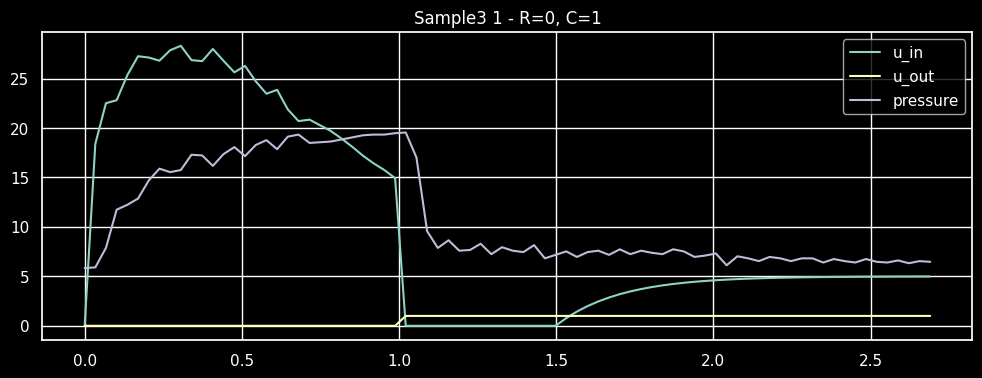

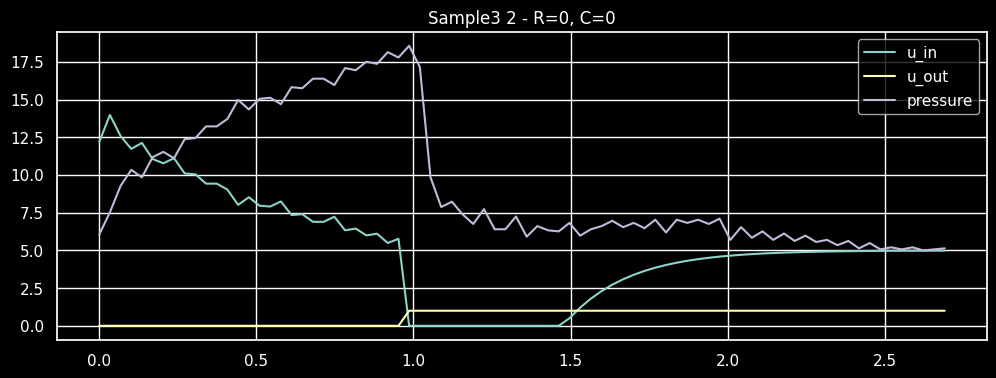

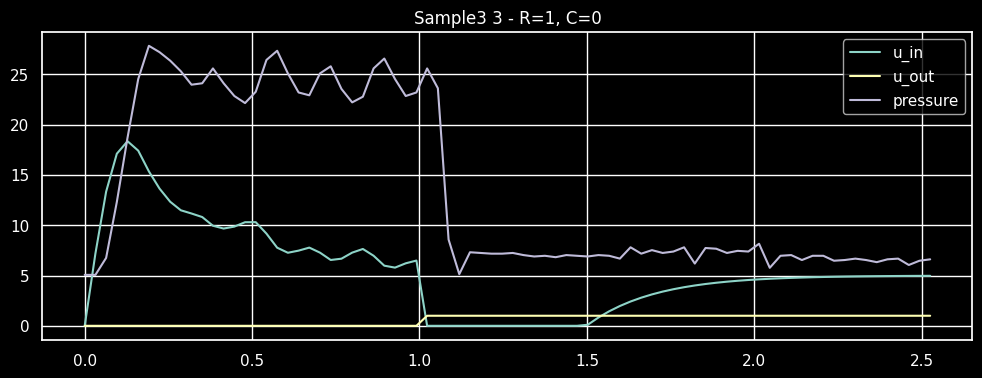

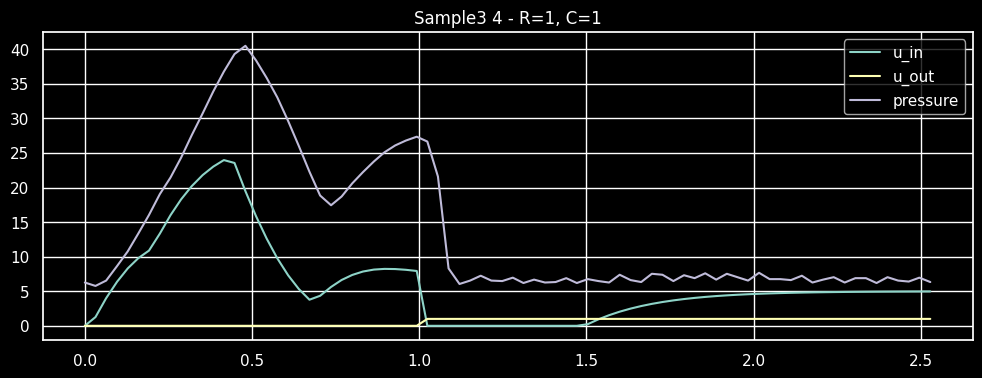

In [ ]:
#==================================================
# 샘플링 시각화
#==================================================
for i in df['breath_id'].unique():
    plot_sample(i, df_train)

In [ ]:
#==================================================
# 데이터셋 정의
#==================================================

class VentilatorDataset(Dataset) :

    def __init__(self,df) -> None:
        super().__init__()
        if "pressure" not in df.columns:
            df['pressure'] = 0
        self.df = df.groupby('breath_id').agg(list).reset_index()
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        self.r5_list          =   self.df['R_5'].values.tolist()
        self.r20_list         =   self.df['R_20'].values.tolist()
        self.r50_list         =   self.df['R_50'].values.tolist()
        self.c10_list         =   self.df['C_10'].values.tolist()
        self.c20_list         =   self.df['C_20'].values.tolist()
        self.c50_list         =   self.df['C_50'].values.tolist()
        self.uin_list         =   self.df['u_in'].values.tolist()
        self.uout_list        =   self.df['u_out'].values.tolist()
        self.pressure_list    =   self.df['pressure'].values.tolist()
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        self.uout_arr       =   np.array(self.uout_list)
        self.pressure_arr   =   np.array(self.pressure_list)
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        self.prepare_data()

    def __len__(self) :
        return self.df.shape[0]

    def prepare_data(self) :
        r5_arr              =   np.array(self.r5_list)
        r20_arr             =   np.array(self.r20_list)
        r50_arr             =   np.array(self.r50_list)
        c10_arr             =   np.array(self.c10_list)
        c20_arr             =   np.array(self.c20_list)
        c50_arr             =   np.array(self.c50_list)
        uin_arr             =   np.array(self.uin_list)
        self.uout_arr       =   np.array(self.uout_list)
        self.pressure_arr   =   np.array(self.pressure_list)
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        self.input_arr = np.concatenate([
                                        r5_arr[:,None],
                                        r20_arr[:,None],
                                        r50_arr[:,None],
                                        c10_arr[:,None],
                                        c20_arr[:,None],
                                        c50_arr[:,None],
                                        uin_arr[:,None],
                                            np.cumsum(uin_arr,1)[:,None],
                                        self.uout_arr[:,None]
                                        ], 1 ).transpose(0, 2, 1)


    def __getitem__(self, idx) :
        data    =  {
                        "input"     : torch.tensor(self.input_arr[idx]    , dtype=float),
                        "u_out"     : torch.tensor(self.uout_arr[idx]     , dtype=float),
                        "p"         : torch.tensor(self.pressure_arr[idx] , dtype=float),
                    }
        return data

In [ ]:
# 피쳐확인
df.columns

Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'pressure', 'cross',
       'cross2', 'area', 'time_step_cumsum', 'u_in_cumsum', 'u_in_lag1',
       'u_out_lag1', 'u_in_lag_back1', 'u_out_lag_back1', 'u_in_lag2',
       'u_out_lag2', 'u_in_lag_back2', 'u_out_lag_back2', 'u_in_lag3',
       'u_out_lag3', 'u_in_lag_back3', 'u_out_lag_back3', 'u_in_lag4',
       'u_out_lag4', 'u_in_lag_back4', 'u_out_lag_back4', 'fft_u_in',
       'fft_u_in_w', 'envelope', 'phase', 'unwrapped_phase', 'phase_shift1',
       'IF', 'breath_id__u_in__max', 'breath_id__u_in__mean',
       'breath_id__u_in__diffmax', 'breath_id__u_in__diffmean', 'u_in_diff1',
       'u_out_diff1', 'u_in_diff2', 'u_out_diff2', 'u_in_diff3', 'u_out_diff3',
       'u_in_diff4', 'u_out_diff4', 'one', 'count', 'u_in_cummean',
       'breath_id_lag', 'breath_id_lag2', 'breath_id_lagsame',
       'breath_id_lag2same', 'breath_id__u_in_lag', 'breath_id__u_in_lag2',
       'time_step_diff', 'ewm_u_in_mean', '15_in_sum', '15_in_m

In [ ]:
#==================================================
# 데이터셋 생성
#==================================================
dataset = VentilatorDataset(df)

In [ ]:
# #==================================================
# # 트테정의
# #==================================================

# trainset        = VentilatorDataset(df_train)
# valset          = VentilatorDataset(df_train.iloc[:].copy().reset_index(drop=True))
# testset         = VentilatorDataset(df_test)

# trainloader     = DataLoader (dataset=trainset,batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True, worker_init_fn=worker_init_fn)
# valloader       = DataLoader (dataset=valset,  batch_size=batch_size, shuffle=False,num_workers=num_workers, pin_memory=True,)
# testloader      = DataLoader (dataset=testset, batch_size=batch_size, shuffle=False,num_workers=num_workers, pin_memory=True,)

## 3. 모델생성
------------------------------------------------------------
* 2 Layer MLP
* Bidirectional LSTM
* Prediction dense layer


In [ ]:
import torch
import torch.nn as nn


class RNNModel(nn.Module):
    def __init__(
        self,
        input_dim=4,
        lstm_dim=256,
        dense_dim=256,
        logit_dim=256,
        num_classes=1,
    ):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, dense_dim // 2),
            nn.ReLU(),
            nn.Linear(dense_dim // 2, dense_dim),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(dense_dim, lstm_dim, batch_first=True, bidirectional=True)

        self.logits = nn.Sequential(
            nn.Linear(lstm_dim * 2, logit_dim),
            nn.ReLU(),
            nn.Linear(logit_dim, num_classes),
        )

    def forward(self, x):
        x = x.float()
        features = self.mlp(x)
        features, _ = self.lstm(features)
        pred = self.logits(features)
        return pred


## 4. optimizer 와 loss function 생성
------------------------------------------------------------

In [ ]:
def compute_metric(df, preds):
    """
    Metric for the problem, as I understood it.
    """

    y = np.array(df['pressure'].values.tolist())
    w = 1 - np.array(df['u_out'].values.tolist())

    assert y.shape == preds.shape and w.shape == y.shape, (y.shape, preds.shape, w.shape)

    mae = w * np.abs(y - preds)
    mae = mae.sum() / w.sum()

    return mae


class VentilatorLoss(nn.Module):
    """
    Directly optimizes the competition metric
    """
    def __call__(self, preds, y, u_out):
        w = 1 - u_out
        mae = w * (y - preds).abs()
        mae = mae.sum(-1) / w.sum(-1)

        return mae

## 5. 학습(fit)
------------------------------------------------------------

In [ ]:
def fit(
    model,
    train_dataset,
    val_dataset,
    loss_name="L1Loss",
    optimizer="Adam",
    epochs=50,
    batch_size=32,
    val_bs=32,
    warmup_prop=0.1,
    lr=1e-3,
    num_classes=1,
    verbose=1,
    first_epoch_eval=0,
    device="cuda"
):
    avg_val_loss = 0.

    # Optimizer
    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=lr)

    # Data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=worker_init_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=val_bs,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # Loss
#     loss_fct = getattr(torch.nn, loss_name)(reduction="none")
    loss_fct = VentilatorLoss()

    # Scheduler
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = int(epochs * len(train_loader))
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps, num_training_steps
    )

    for epoch in range(epochs):
        model.train()
        model.zero_grad()
        start_time = time()

        avg_loss = 0
        for data in train_loader:
            pred = model(data['input'].float().to(device)).squeeze(-1)

            loss = loss_fct(
                pred,
                data['p'].to(device),
                data['u_out'].to(device),
            ).mean()
            loss.backward()
            avg_loss += loss.item() / len(train_loader)

            optimizer.step()
            scheduler.step()

            for param in model.parameters():
                param.grad = None

        model.eval()
        mae, avg_val_loss = 0, 0
        preds = []

        with torch.no_grad():
            for data in val_loader:
                pred = model(data['input'].to(device)).squeeze(-1)

                loss = loss_fct(
                    pred.detach(),
                    data['p'].to(device),
                    data['u_out'].to(device),
                ).mean()
                avg_val_loss += loss.item() / len(val_loader)

                preds.append(pred.detach().cpu().numpy())

        preds = np.concatenate(preds, 0)
        mae = compute_metric(val_dataset.df, preds)

        elapsed_time = time() - start_time
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            lr = scheduler.get_last_lr()[0]
            print(
                f"Epoch {epoch + 1:02d}/{epochs:02d} \t lr={lr:.1e}\t t={elapsed_time:.0f}s \t"
                f"loss={avg_loss:.3f}",
                end="\t",
            )

            if (epoch + 1 >= first_epoch_eval) or (epoch + 1 == epochs):
                print(f"val_loss={avg_val_loss:.3f}\tmae={mae:.3f}")
            else:
                print("")

    del (val_loader, train_loader, loss, data, pred)
    gc.collect()
    torch.cuda.empty_cache()

    return preds


## 6. 예측(Predict)
------------------------------------------------------------

In [ ]:
def predict(model,dataset,batch_size=64,device="cuda") :
    model.eval()

    loader = DataLoader(
                          dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=num_workers
                       )

    preds = []
    with torch.no_grad():
        for data in loader:
            pred = model(data['input'].to(device)).squeeze(-1)
            preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds, 0)
    return preds


## 7. 훈련(Train)
------------------------------------------------------------

In [ ]:
def train(config, df_train, df_val, df_test, fold):
    """
    Trains and validate a model.

    Args:
        config (Config): Parameters.
        df_train (pandas dataframe): Training metadata.
        df_val (pandas dataframe): Validation metadata.
        df_test (pandas dataframe): Test metadata.
        fold (int): Selected fold.

    Returns:
        np array: Study validation predictions.
    """

    seed_everything(config.seed)

    model = RNNModel(
        input_dim=config.input_dim,
        lstm_dim=config.lstm_dim,
        dense_dim=config.dense_dim,
        logit_dim=config.logit_dim,
        num_classes=config.num_classes,
    ).to(config.device)
    model.zero_grad()

    train_dataset = VentilatorDataset(df_train)
    val_dataset = VentilatorDataset(df_val)
    test_dataset = VentilatorDataset(df_test)

    n_parameters = count_parameters(model)

    print(f"    -> {len(train_dataset)} training breathes")
    print(f"    -> {len(val_dataset)} validation breathes")
    print(f"    -> {n_parameters} trainable parameters\n")

    pred_val = fit(
        model,
        train_dataset,
        val_dataset,
        loss_name=config.loss,
        optimizer=config.optimizer,
        epochs=config.epochs,
        batch_size=config.batch_size,
        val_bs=config.val_bs,
        lr=config.lr,
        warmup_prop=config.warmup_prop,
        verbose=config.verbose,
        first_epoch_eval=config.first_epoch_eval,
        device=config.device,
    )

    pred_test = predict(
        model,
        test_dataset,
        batch_size=config.val_bs,
        device=config.device
    )

    if config.save_weights:
        save_model_weights(
            model,
            f"{config.selected_model}_{fold}.pt",
            cp_folder="",
        )

    del (model, train_dataset, val_dataset, test_dataset)
    gc.collect()
    torch.cuda.empty_cache()

    return pred_val, pred_test


## 8. k-fold 교차검증
--------------------------

### 8.1 차원축소
-------------------------------------------------------------------------------------

In [ ]:
def apply_pca(df, components_ratio=0.90, seed=2023):
    """
    주어진 데이터프레임에 PCA를 적용하여 주성분을 추출하고,
    변환된 데이터프레임을 반환

    Args:
        df (pd.DataFrame): PCA를 적용할 데이터프레임.
        components_ratio (float): 원본 데이터의 정보를 표현할 주성분의 비율.
        seed (int): 랜덤 시드.

    Returns:
        pd.DataFrame: PCA를 적용한 데이터프레임.
    """
    # 표준화
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(df.iloc[:, 7:])  # 7번 컬럼기준

    # PCA 모델 생성
    pca = PCA(n_components=components_ratio, whiten=True, random_state=seed)

    # PCA 학습 및 변환
    df_pca = pd.DataFrame(data=pca.fit_transform(df_standardized), columns=[f'PC{i}' for i in range(pca.n_components_)])

    return df_pca


In [ ]:
# PCA적용(보류중)
df_pca_train = apply_pca(df_train)
df_pca_test = apply_pca(df_test)

In [ ]:
def k_fold(config, df, df_test):
    """
    Performs a patient grouped k-fold cross validation.
    """

    pred_oof = np.zeros(len(df))
    preds_test = []

    gkf = GroupKFold(n_splits=config.k)
    splits = list(gkf.split(X=df, y=df, groups=df["breath_id"]))

    for i, (train_idx, val_idx) in enumerate(splits):
        if i in config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {config.k}  -------------\n")

            df_train = df.iloc[train_idx].copy().reset_index(drop=True)
            df_val = df.iloc[val_idx].copy().reset_index(drop=True)

            pred_val, pred_test = train(config, df_train, df_val, df_test, i)

            pred_oof[val_idx] = pred_val.flatten()
            preds_test.append(pred_test.flatten())

    print(f'\n -> CV MAE : {compute_metric(df, pred_oof) :.3f}')

    return pred_oof, np.mean(preds_test, 0)


## 9. 메인실행
--------------------------

In [ ]:
class Config:
    """
    훈련용파라미터 사용
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 5
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    selected_model = 'rnn'
    input_dim = 5

    dense_dim = 512
    lstm_dim = 512
    logit_dim = 512
    num_classes = 1

    # Training
    loss = "L1Loss"  # not used
    optimizer = "Adam"
    batch_size = 128
    epochs = 200

    lr = 1e-3
    warmup_prop = 0

    val_bs = 256
    first_epoch_eval = 0


In [ ]:
df_train.columns

Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'pressure', 'cross',
       'cross2', 'area', 'time_step_cumsum', 'u_in_cumsum', 'u_in_lag1',
       'u_out_lag1', 'u_in_lag_back1', 'u_out_lag_back1', 'u_in_lag2',
       'u_out_lag2', 'u_in_lag_back2', 'u_out_lag_back2', 'u_in_lag3',
       'u_out_lag3', 'u_in_lag_back3', 'u_out_lag_back3', 'u_in_lag4',
       'u_out_lag4', 'u_in_lag_back4', 'u_out_lag_back4', 'fft_u_in',
       'fft_u_in_w', 'envelope', 'phase', 'unwrapped_phase', 'phase_shift1',
       'IF', 'breath_id__u_in__max', 'breath_id__u_in__mean',
       'breath_id__u_in__diffmax', 'breath_id__u_in__diffmean', 'u_in_diff1',
       'u_out_diff1', 'u_in_diff2', 'u_out_diff2', 'u_in_diff3', 'u_out_diff3',
       'u_in_diff4', 'u_out_diff4', 'one', 'count', 'u_in_cummean',
       'breath_id_lag', 'breath_id_lag2', 'breath_id_lagsame',
       'breath_id_lag2same', 'breath_id__u_in_lag', 'breath_id__u_in_lag2',
       'time_step_diff', 'ewm_u_in_mean', '15_in_sum', '15_in_m

In [ ]:
pred_oof, pred_test = k_fold(
    Config,
    df_train,
    df_test,
)

## 10. 제출
-----------------------

In [ ]:
def plot_prediction(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']

    plt.figure(figsize=(12, 4))
    for col in ['pred', 'pressure', 'u_out']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)

    metric = compute_metric(df_breath, df_breath['pred'])

    plt.legend()
    plt.title(f'Sample {sample_id} - MAE={metric:.3f}')


In [ ]:
df_train["pred"] = pred_oof

In [ ]:
for i in df_train['breath_id'].unique()[:5]:
    plot_prediction(i, df_train)

In [ ]:
df_test['pred'] = pred_test

for i in df_test['breath_id'].unique()[:5]:
    plot_prediction(i, df_test)

In [ ]:
sub['pressure'] = pred_test
sub.to_csv('submission.csv', index=False)
